In [1]:
import emlddmm
%matplotlib notebook
import requests
import json
import numpy as np
from os.path import join,split,splitext,exists


In [2]:
reference_url = 'https://download.brainlib.org/hackathon/2022_GYBS/input/fMOST/reference/average_template_25_mm_ASL.nii.gz'
subject_url = 'https://download.brainlib.org/hackathon/2022_GYBS/input/fMOST/subject/194062_red_mm_SLA.nii.gz'

In [3]:
dest_path = split(reference_url)[-1]
src_path = split(subject_url)[-1]
dest_path,src_path

('average_template_25_mm_ASL.nii.gz', '194062_red_mm_SLA.nii.gz')

In [4]:
src_down = src_path[:-7] + '_down.vtk'

In [5]:
# check if reference image is already downloaded and download if not.
if not exists(dest_path):
    r = requests.get(reference_url, stream=True)
    with open(dest_path, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)  
else:
    print(f'{dest_path} already exists')
# check if the downsampled subject exists
if exists(src_down):
    print(f'{src_down} exists')
    src_path = src_down
# if no downsampled subject and the original doesn't exist, download it.
elif not exists(src_path):
    r = requests.get(subject_url, stream=True)
    with open(src_path, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)     
else:
    print(f'{src_path} already exists')

average_template_25_mm_ASL.nii.gz already exists
194062_red_mm_SLA_down.vtk exists


In [16]:
with open('configMD816_fMOST_to_CCF.json', 'r') as f:
    config = json.load(f)
print(config)

{'device': 'cpu', 'n_iter': [100, 50], 'downI': [[14, 14, 14], [10, 10, 10]], 'downJ': [[4, 4, 4], [1, 1, 1]], 'a': [200.0], 'sigmaR': [5000000.0], 'sigmaM': [0.125], 'sigmaB': [0.25], 'sigmaA': [0.375], 'ev': [0.0001], 'eA': [100000.0, 20000.0], 'priors': [[0.9, 0.05, 0.05]], 'update_muA': [0], 'update_muB': [0], 'muB': [0.0], 'order': [3], 'n_draw': [50], 'n_e_step': [3], 'v_start': [50, 0], 'A': [[[0, -1, 0, 0], [0, 0, -1, 0], [-1, 0, 0, 0], [0, 0, 0, 1]]]}


Opening with nibabel, note only 3D images supported
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 528 320 456   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint16
bitpix          : 16
slice_start     : 0
pixdim          : [1.    0.025 0.025 0.025 0.    0.    0.    0.   ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : -0.5
quatern_c       : 0.5
quatern_d       : -0.5
qoffset_x       : -11.375
qoffset_y       :

<IPython.core.display.Javascript object>


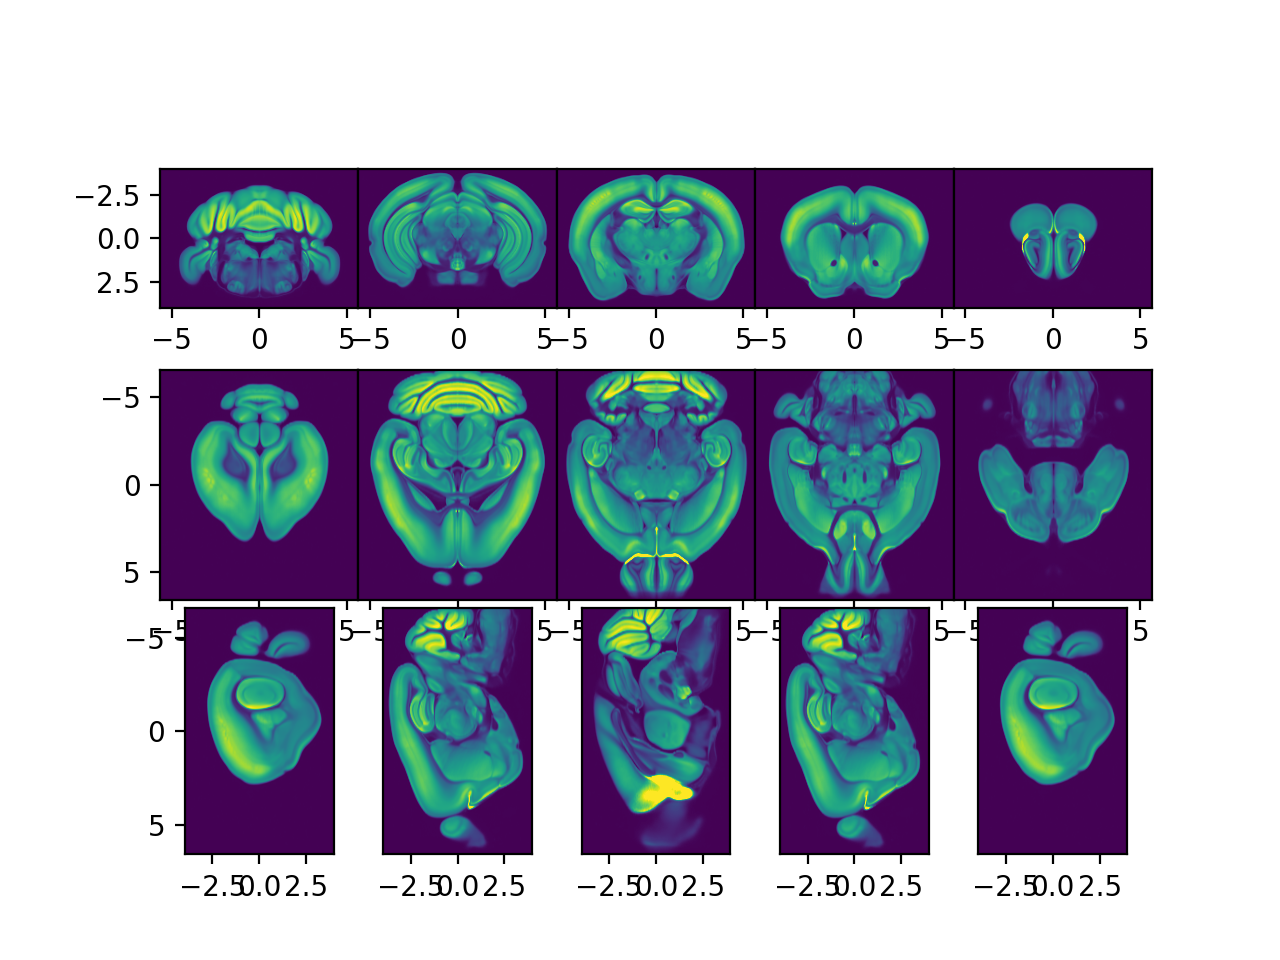

(<Figure size 640x480 with 15 Axes>,
 [[<AxesSubplot:>,
   <AxesSubplot:>,
   <AxesSubplot:>,
   <AxesSubplot:>,
   <AxesSubplot:>],
  [<AxesSubplot:>,
   <AxesSubplot:>,
   <AxesSubplot:>,
   <AxesSubplot:>,
   <AxesSubplot:>],
  [<AxesSubplot:>,
   <AxesSubplot:>,
   <AxesSubplot:>,
   <AxesSubplot:>,
   <AxesSubplot:>]])

In [7]:
# load reference image
xI,I,_,_ = emlddmm.read_data(dest_path)
I = I.astype(float)
# normalize
I /= np.mean(np.abs(I))
I /= np.quantile(I, 0.99)

# initial downsampling so there isn't so much on the gpu
downIs = config['downI']
mindownI = np.min(np.array(downIs),0)
xI,I = emlddmm.downsample_image_domain(xI,I,mindownI)
downIs = [ list((np.array(d)/mindownI).astype(int)) for d in downIs]
# update our config variable
config['downI'] = downIs

# display reference image
emlddmm.draw(I,xI)

<IPython.core.display.Javascript object>


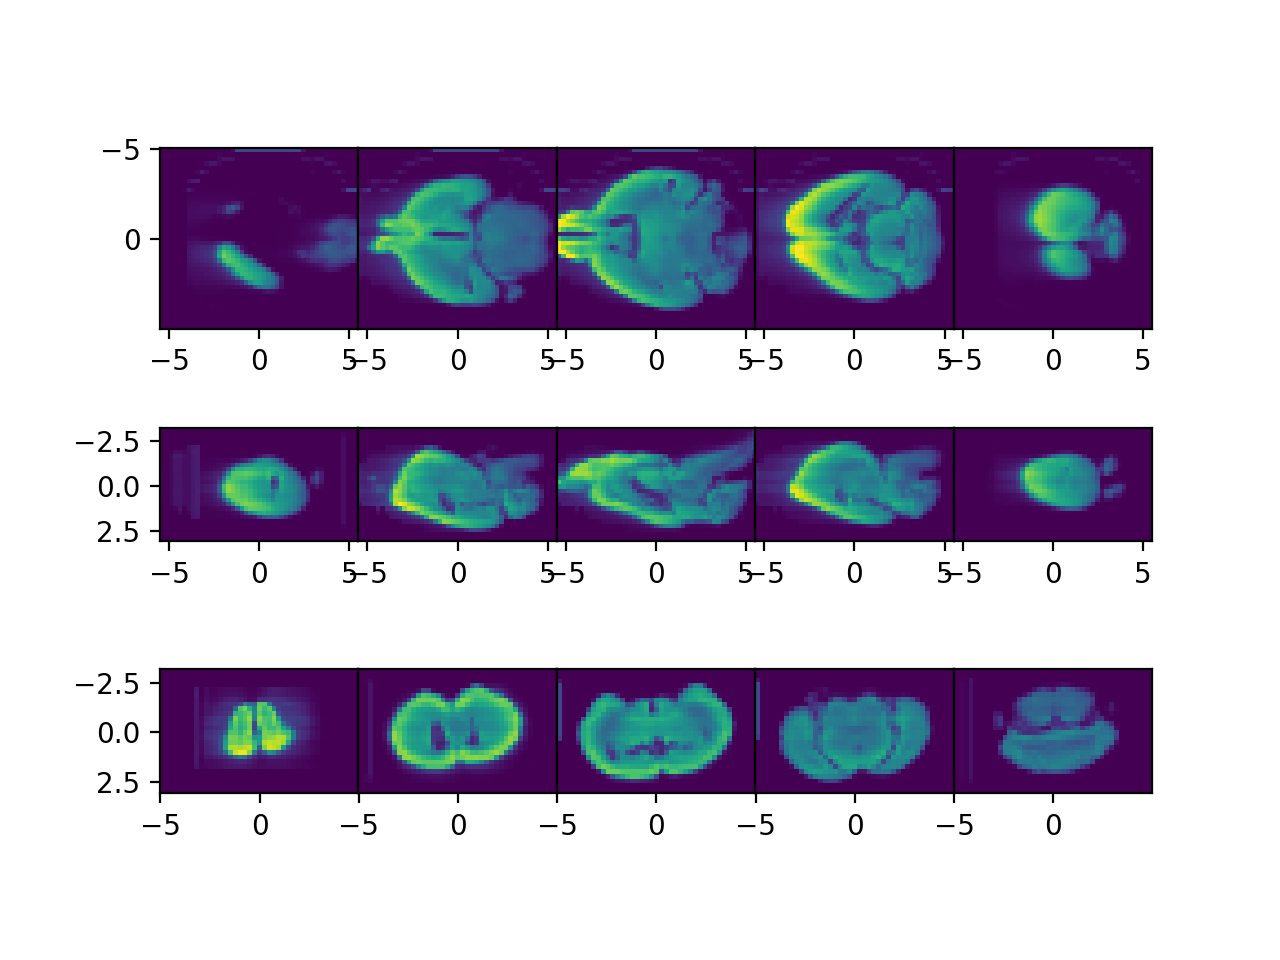

(<Figure size 640x480 with 15 Axes>,
 [[<AxesSubplot:>,
   <AxesSubplot:>,
   <AxesSubplot:>,
   <AxesSubplot:>,
   <AxesSubplot:>],
  [<AxesSubplot:>,
   <AxesSubplot:>,
   <AxesSubplot:>,
   <AxesSubplot:>,
   <AxesSubplot:>],
  [<AxesSubplot:>,
   <AxesSubplot:>,
   <AxesSubplot:>,
   <AxesSubplot:>,
   <AxesSubplot:>]])

In [8]:
# load subject image
xJ,J,_,_ = emlddmm.read_data(src_path)
W0 = np.ones_like(J[0]) # initial mask image
J = J.astype(float)

# normalize
J /= np.mean(np.abs(J))
J /= np.quantile(J, 0.99)

# initial downsampling so there isn't so much on the gpu
downJs = config['downJ']
mindownJ = np.min(np.array(downJs),0)
xJ,J = emlddmm.downsample_image_domain(xJ,J,mindownJ)
W0 = emlddmm.downsample(W0,mindownJ)
downJs = [ list((np.array(d)/mindownJ).astype(int)) for d in downJs]
# update our config variable
config['downJ'] = downJs

emlddmm.draw(J,xJ)

In [17]:
# print inital translation from config file

if 'A' in config:
    A = np.array(config['A']).astype(float).squeeze()
else:
    A = np.eye(4)
print(A)

[[ 0. -1.  0.  0.]
 [ 0.  0. -1.  0.]
 [-1.  0.  0.  0.]
 [ 0.  0.  0.  1.]]


starting to compose sequence with transforms [Transform with data size torch.Size([4, 4]), direction b, and domain <class 'NoneType'>]


<IPython.core.display.Javascript object>


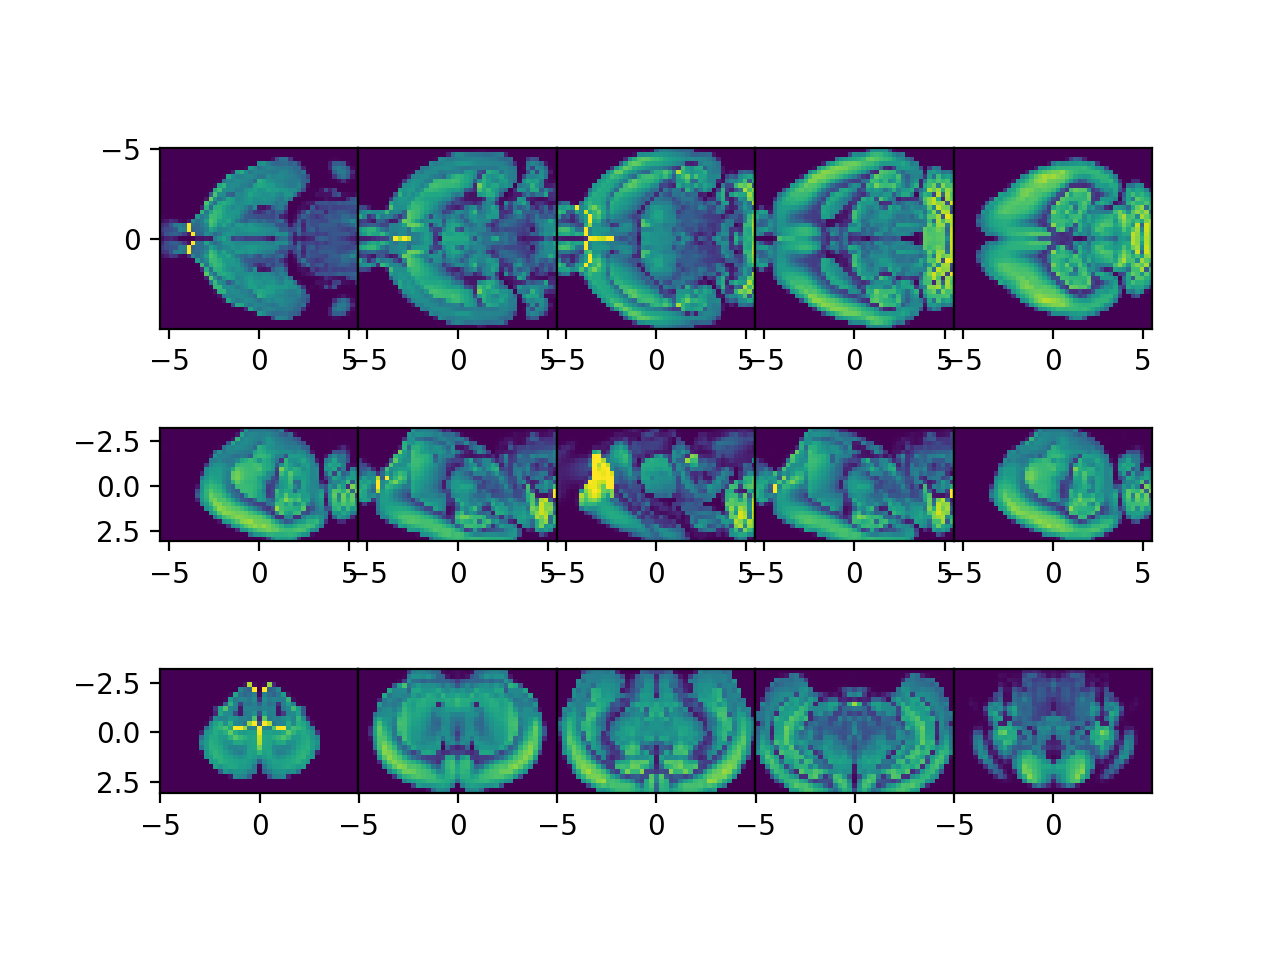

(<Figure size 640x480 with 15 Axes>,
 [[<AxesSubplot:>,
   <AxesSubplot:>,
   <AxesSubplot:>,
   <AxesSubplot:>,
   <AxesSubplot:>],
  [<AxesSubplot:>,
   <AxesSubplot:>,
   <AxesSubplot:>,
   <AxesSubplot:>,
   <AxesSubplot:>],
  [<AxesSubplot:>,
   <AxesSubplot:>,
   <AxesSubplot:>,
   <AxesSubplot:>,
   <AxesSubplot:>]])

In [18]:
# visualize initial affine
tform = emlddmm.compose_sequence([emlddmm.Transform(A,'b')],np.stack(np.meshgrid(*xJ,indexing='ij')))
AI = emlddmm.apply_transform_float(xI,I,tform)
emlddmm.draw(AI,xJ)

Found 2 scales
dv tensor([0.1500, 0.1500, 0.1500])
a scale is 200.0


<IPython.core.display.Javascript object>


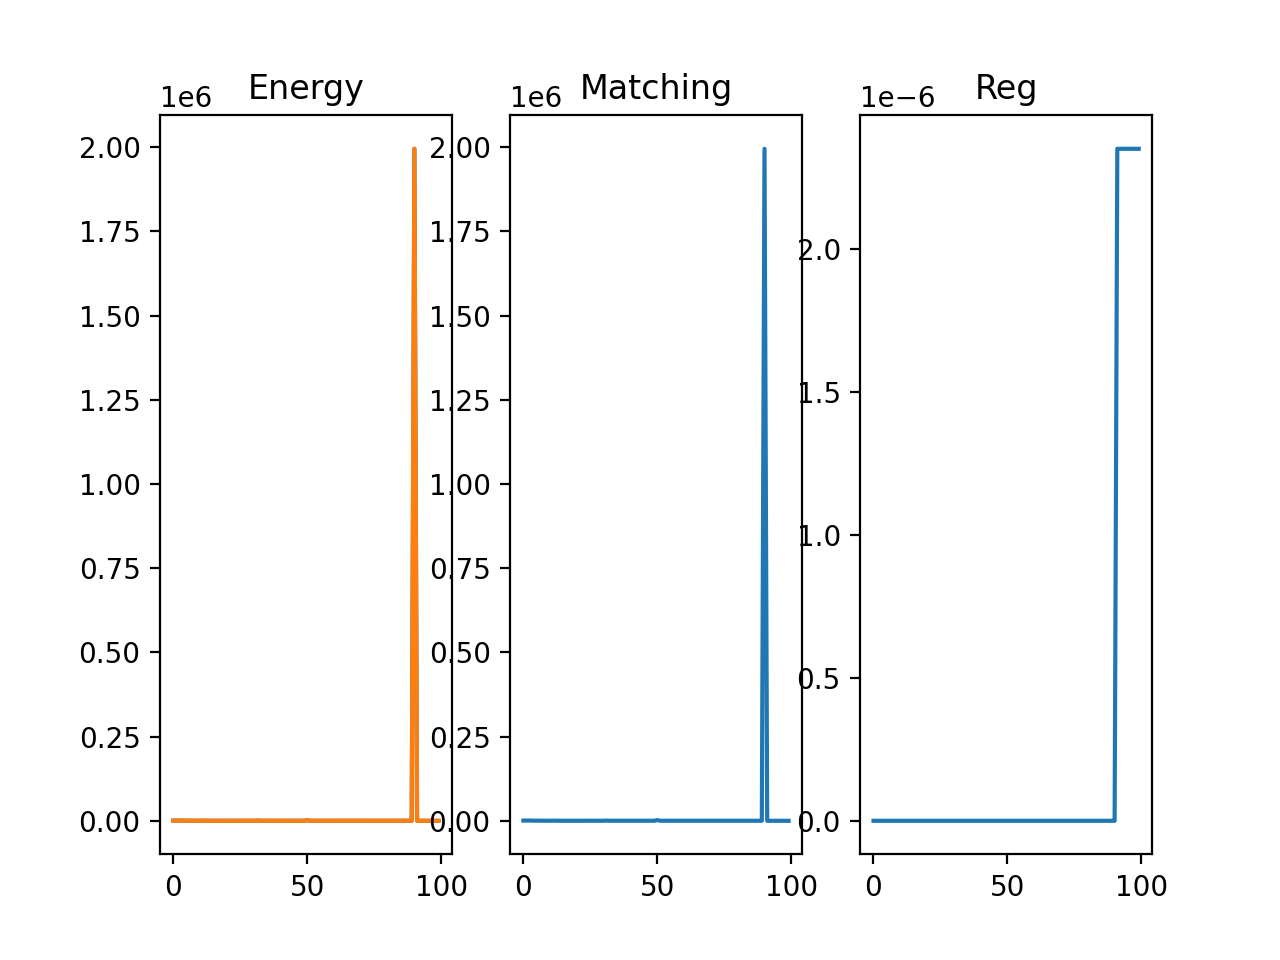

<IPython.core.display.Javascript object>


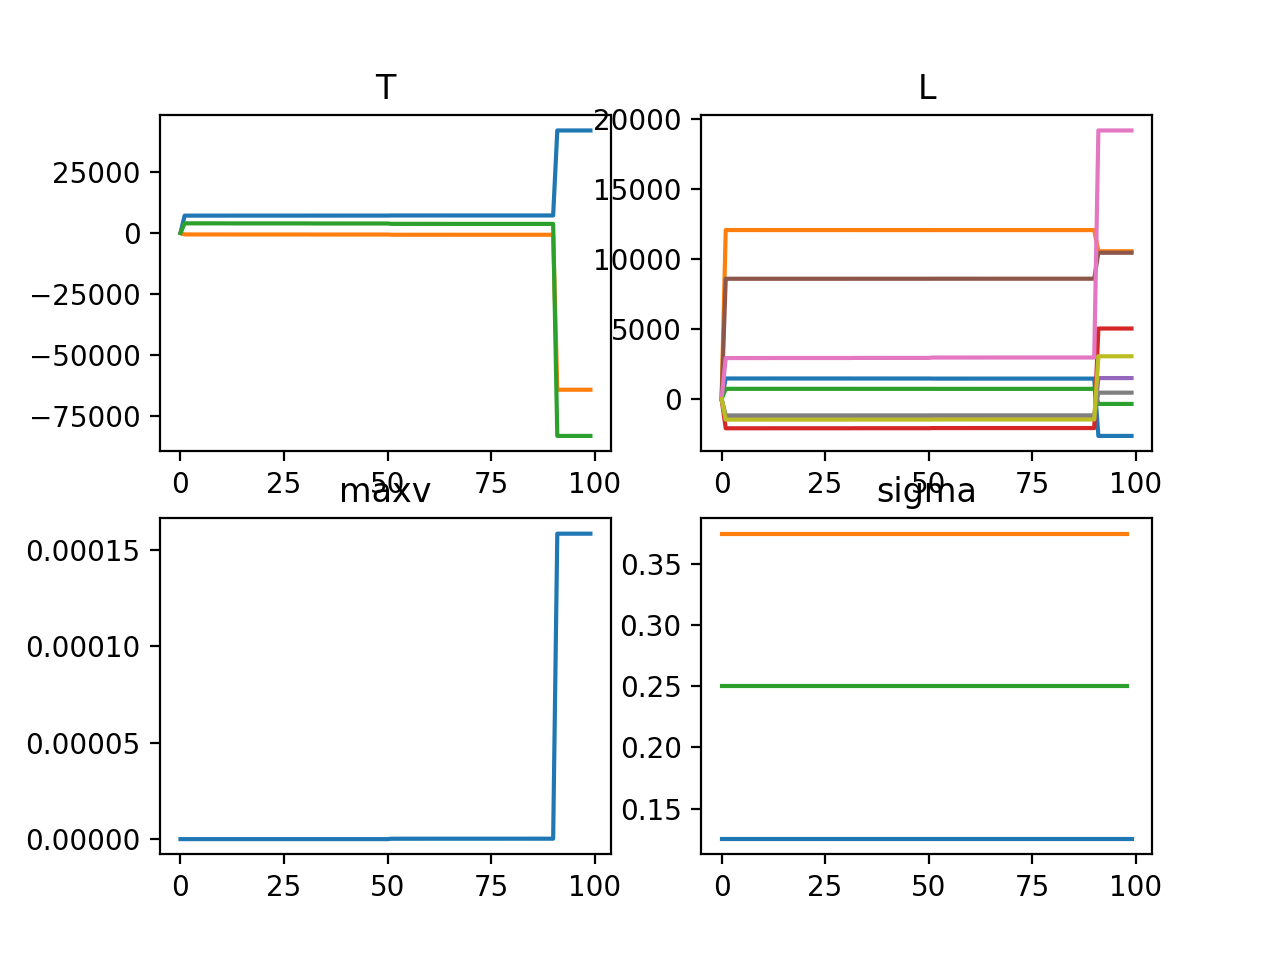

<IPython.core.display.Javascript object>


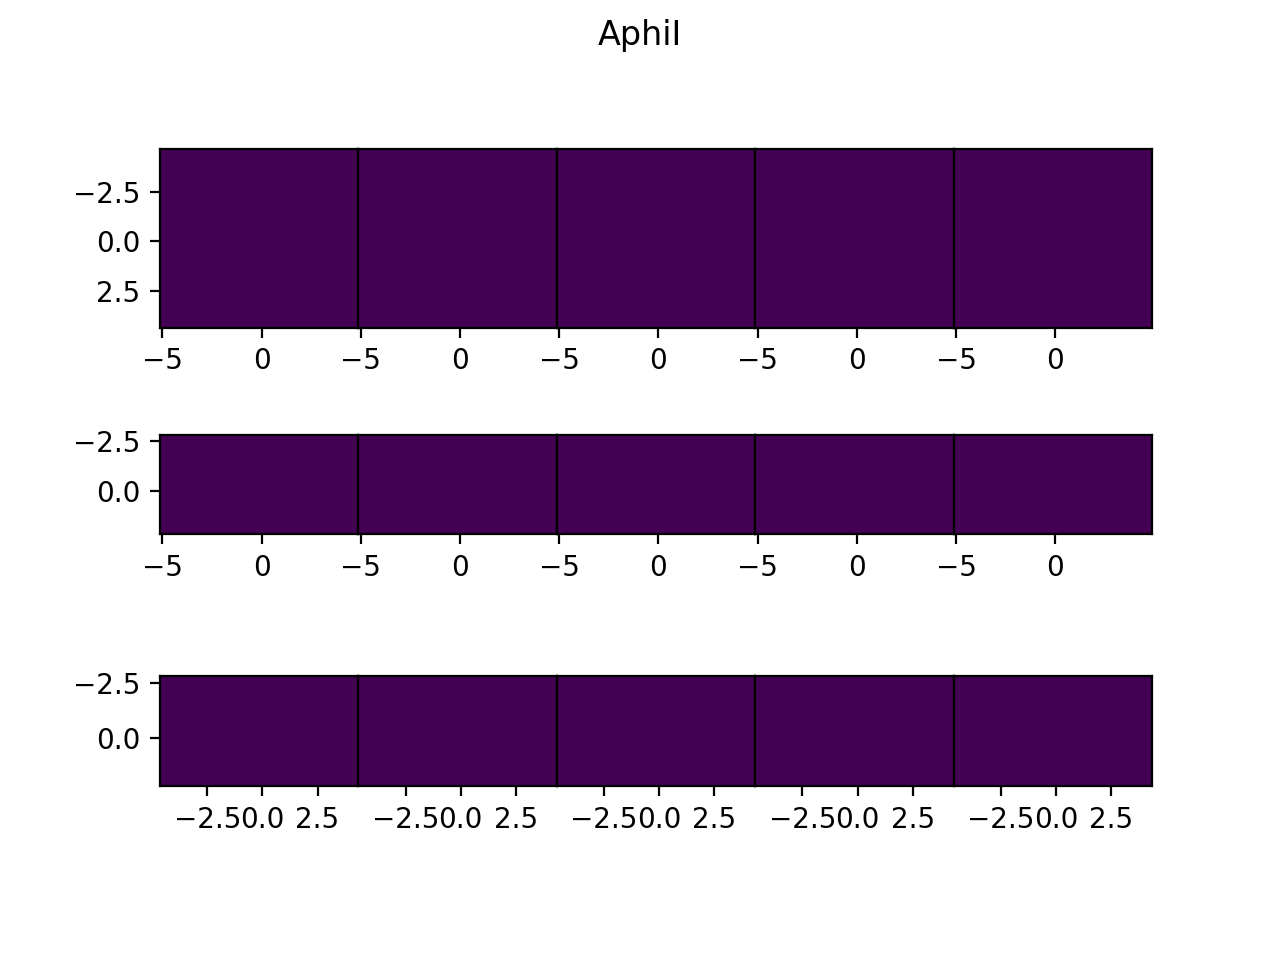

<IPython.core.display.Javascript object>


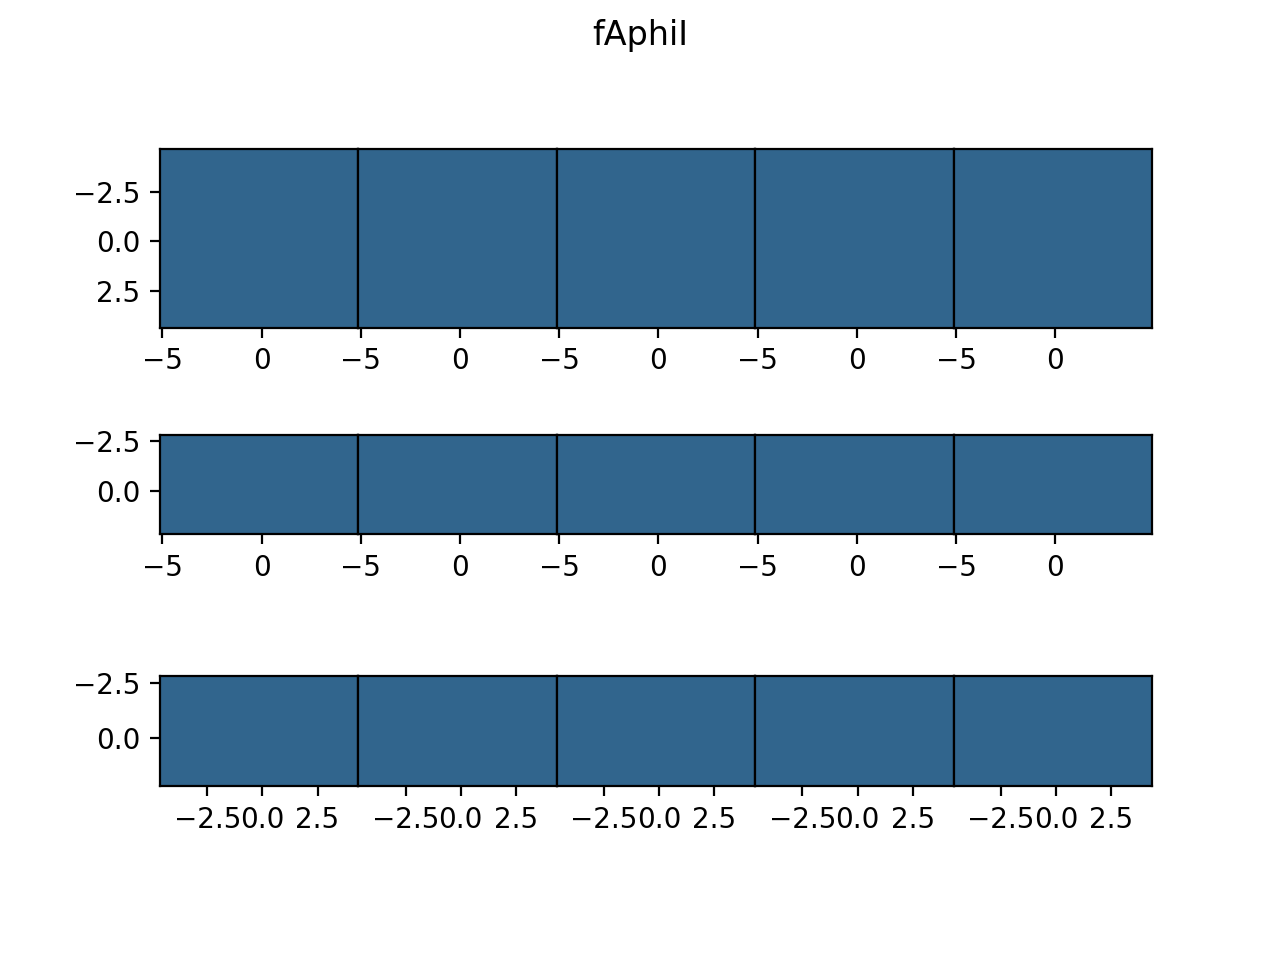

<IPython.core.display.Javascript object>


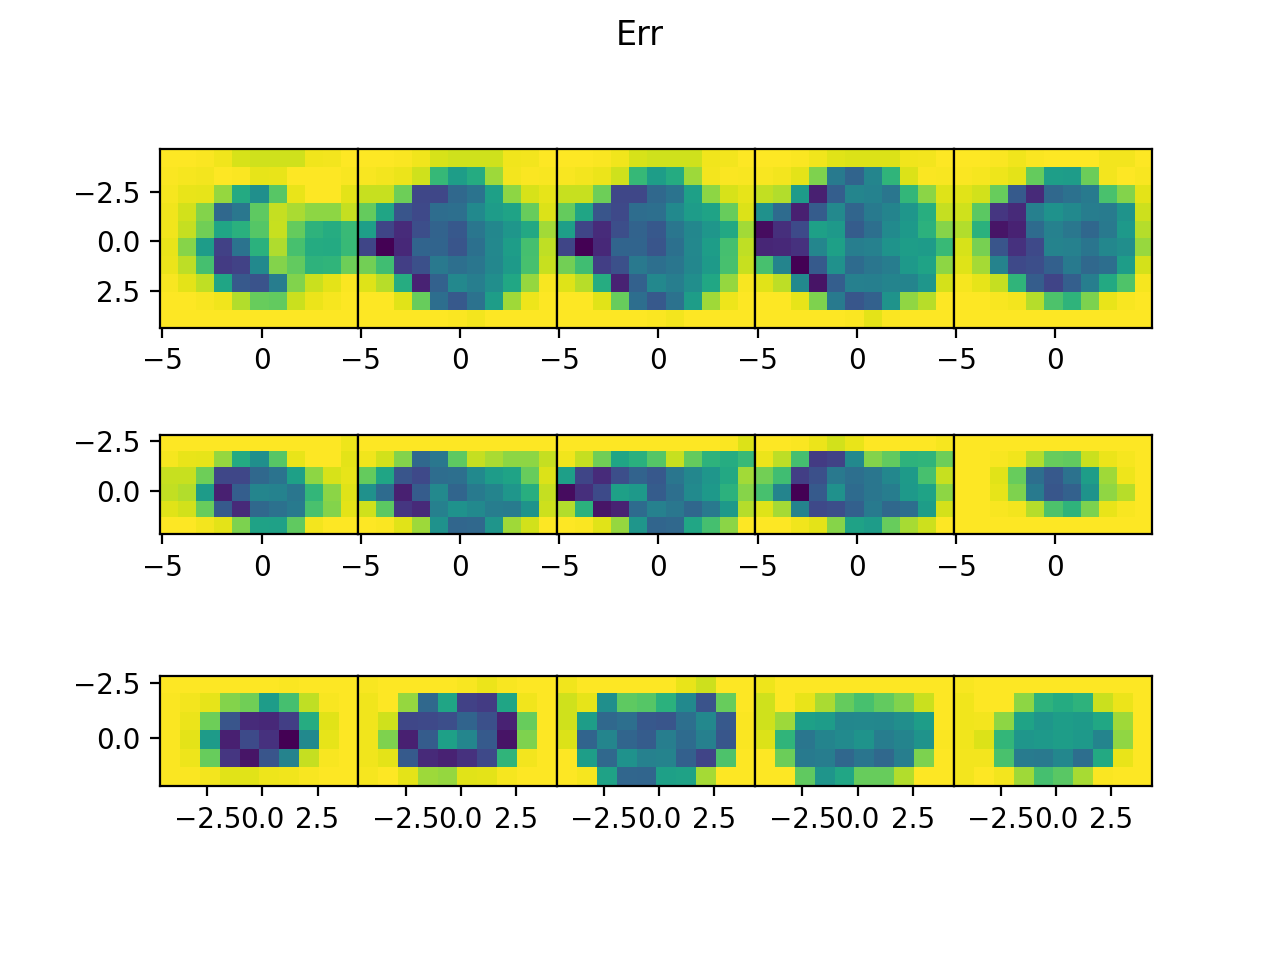

<IPython.core.display.Javascript object>


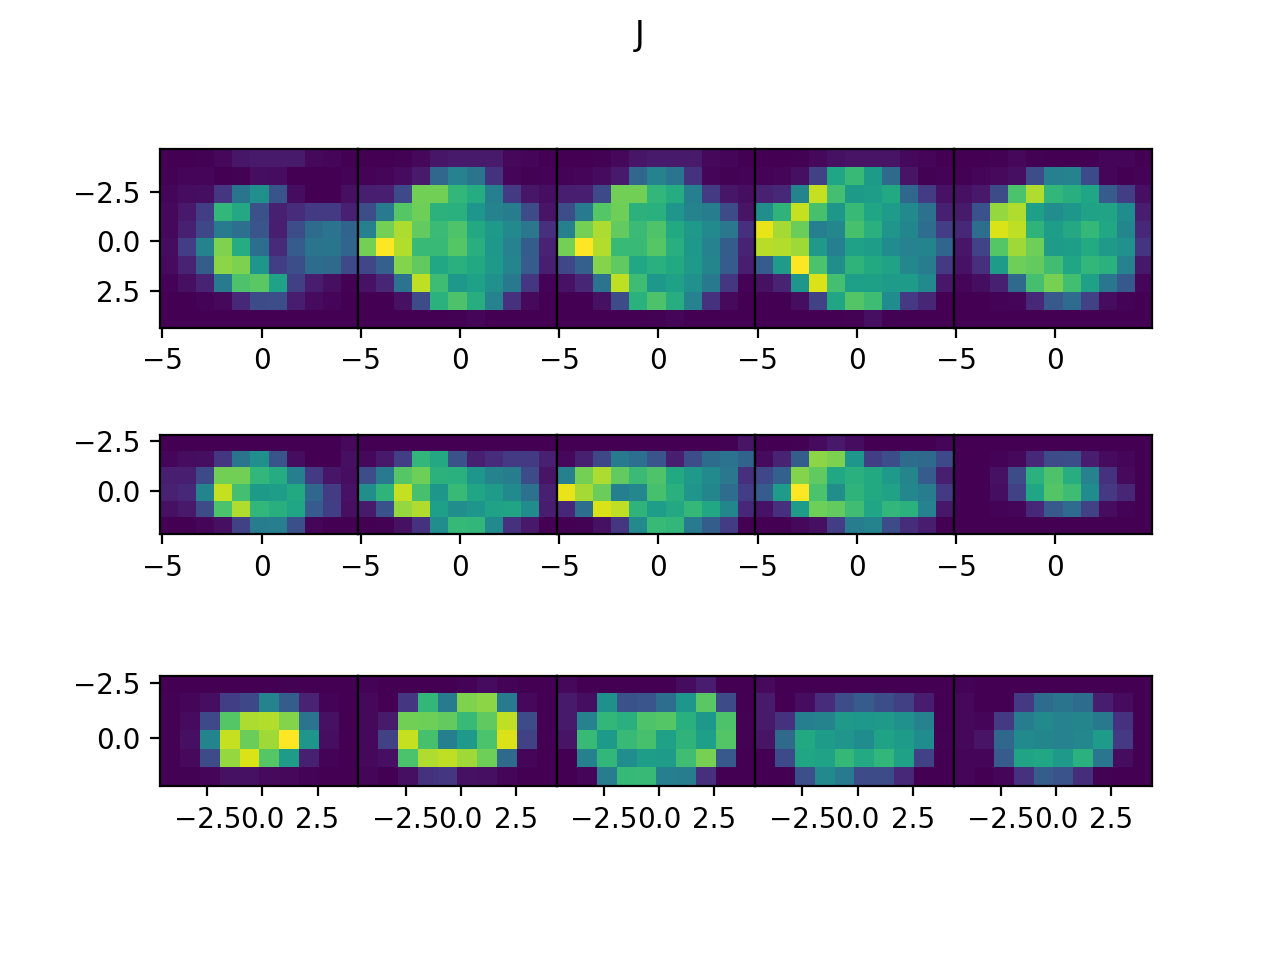

<IPython.core.display.Javascript object>


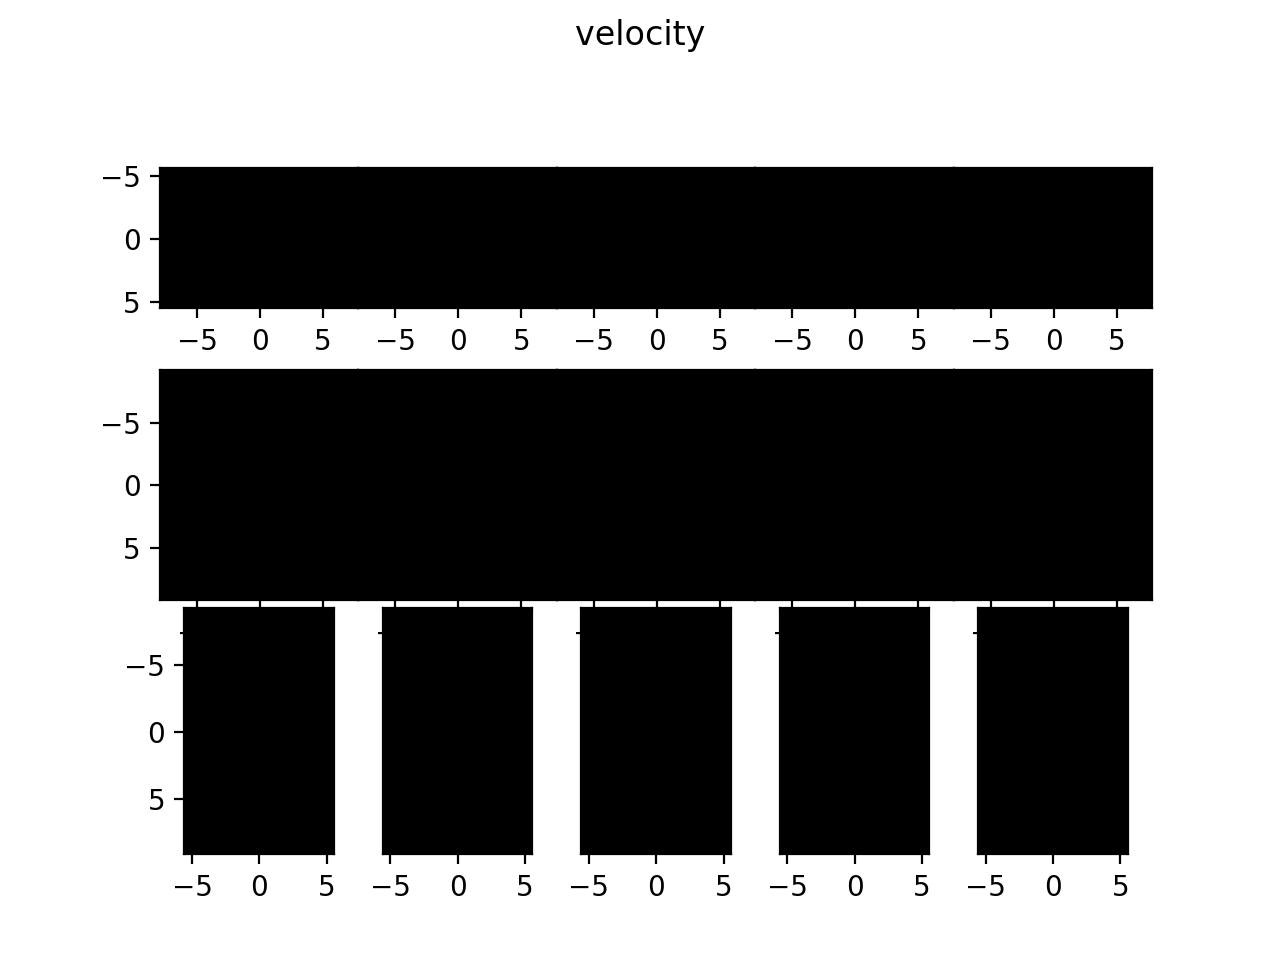

<IPython.core.display.Javascript object>


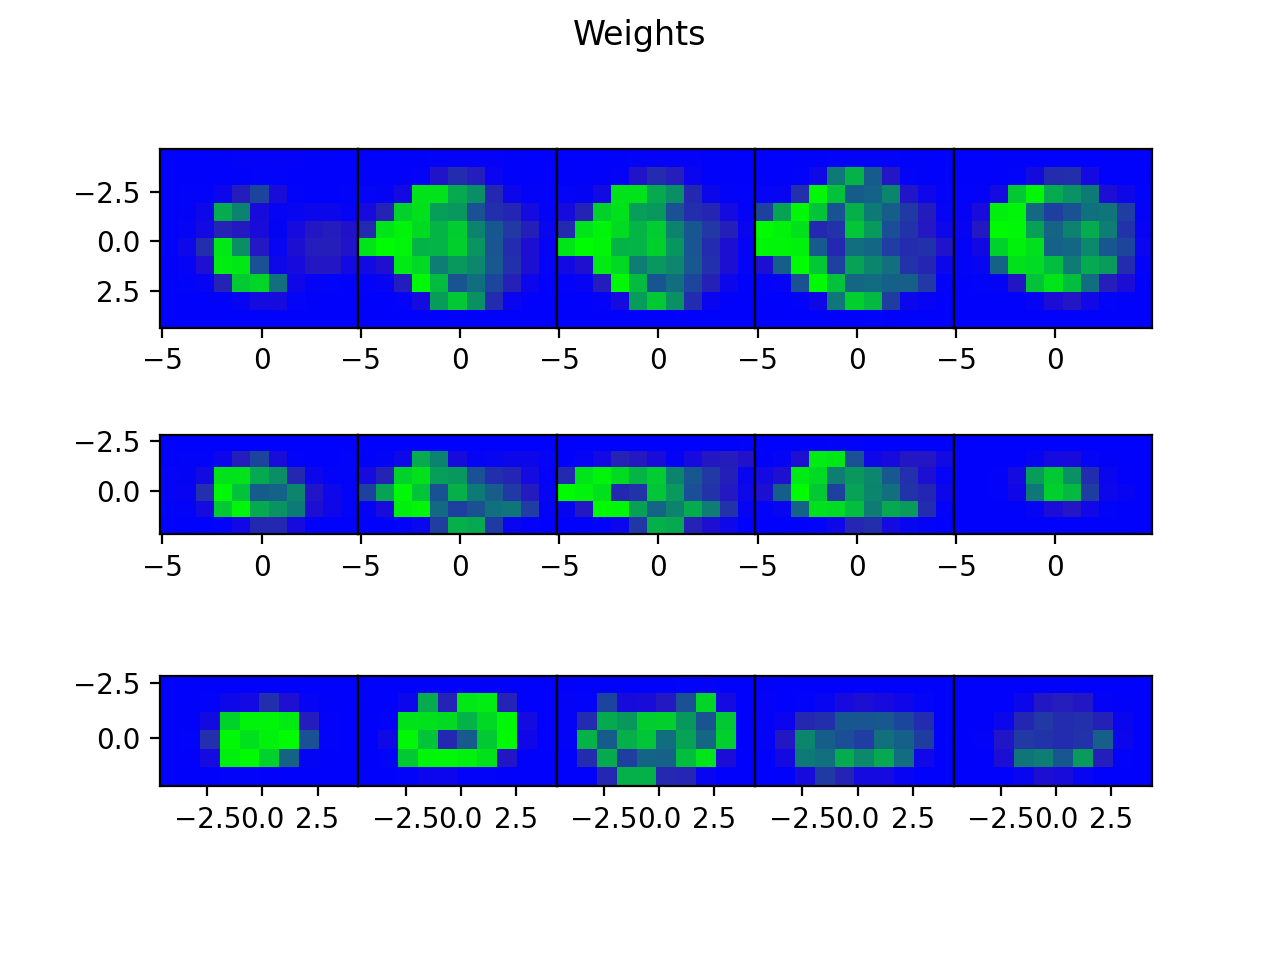

/Users/brysongray/TwardLab/emlddmm/emlddmm.py:89: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 0
Finished iteration 10
Finished iteration 20
Finished iteration 30
Iteration 40, linear oscilating, reducing eA to 90000.0
Finished iteration 40


/Users/brysongray/TwardLab/emlddmm/emlddmm.py:89: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 50
Finished iteration 60
Finished iteration 70
Iteration 80 reducing ev to 9e-05
Iteration 80, translation oscilating, reducing eA to 81000.0
Finished iteration 80
Iteration 90 reducing ev to 8.1e-05
Iteration 90, translation oscilating, reducing eA to 72900.0
Finished iteration 90


/Users/brysongray/TwardLab/emlddmm/emlddmm.py:89: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


dv tensor([0.1500, 0.1500, 0.1500])
a scale is 200.0


/Users/brysongray/TwardLab/emlddmm/emlddmm.py:948: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v = torch.tensor(v,device=device,dtype=dtype)
/Users/brysongray/TwardLab/emlddmm/emlddmm.py:963: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(A,device=device,dtype=dtype).detach().clone()


<IPython.core.display.Javascript object>


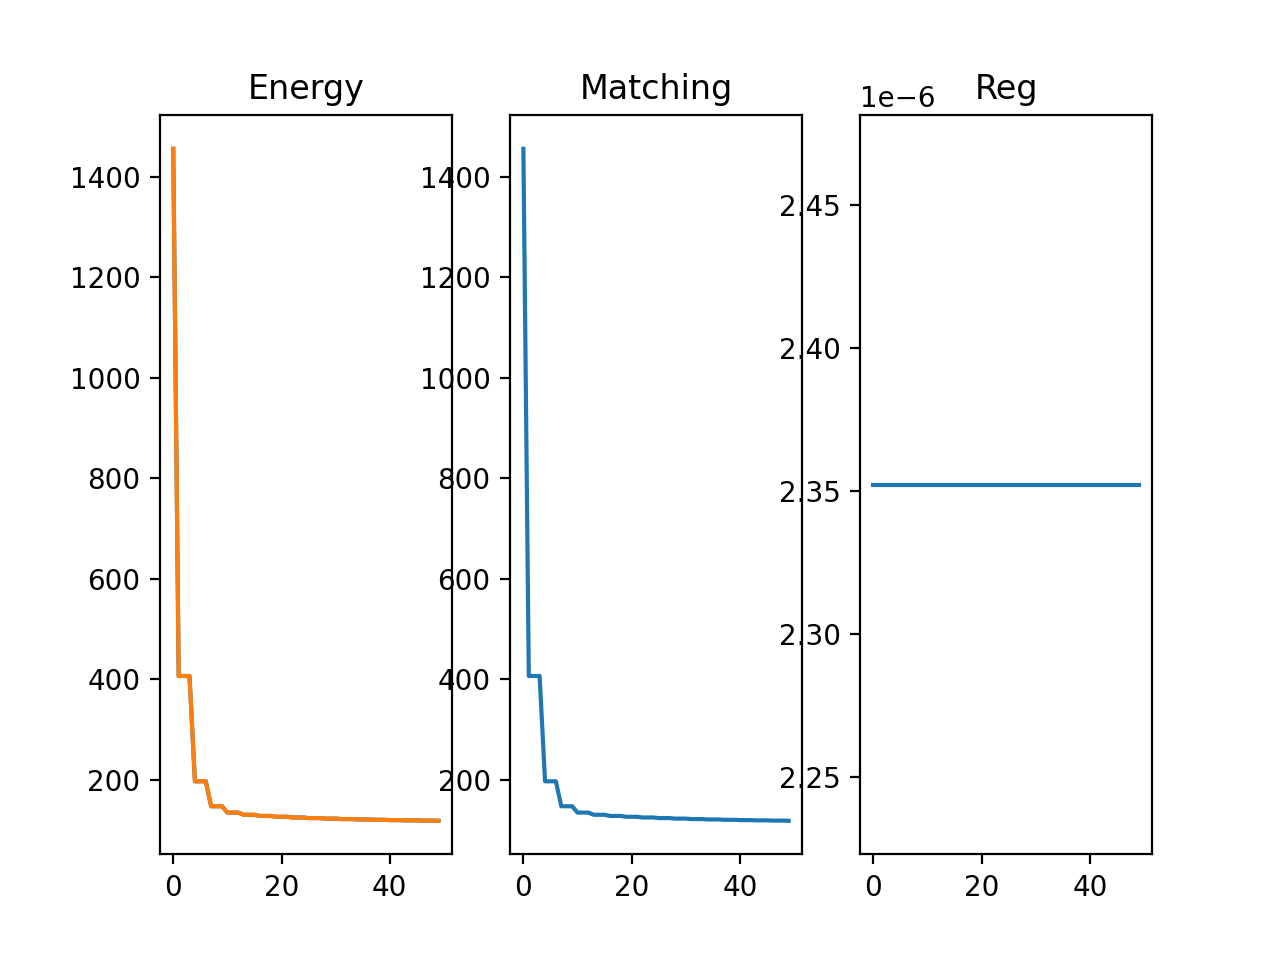

<IPython.core.display.Javascript object>


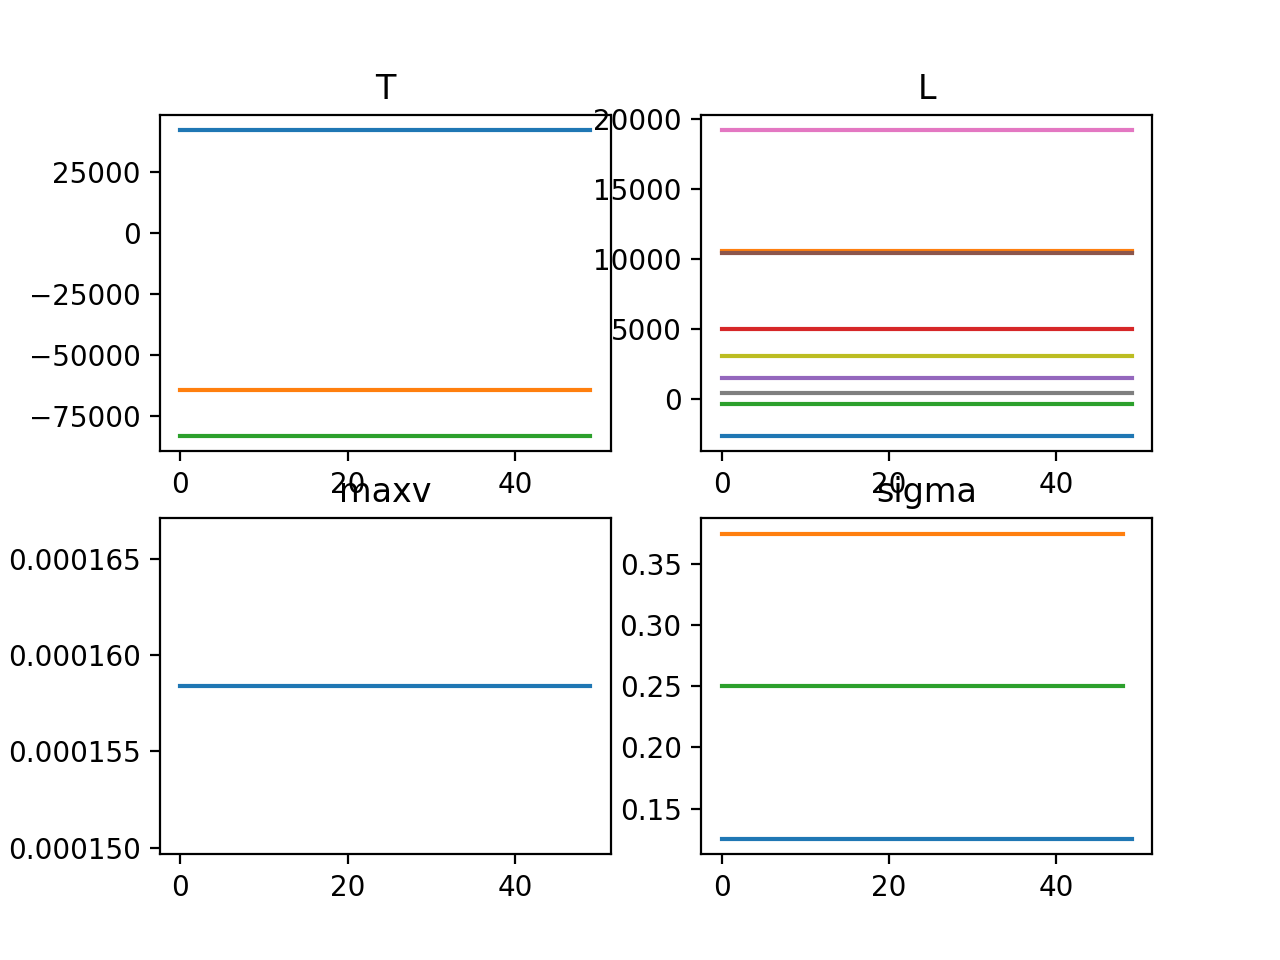

<IPython.core.display.Javascript object>


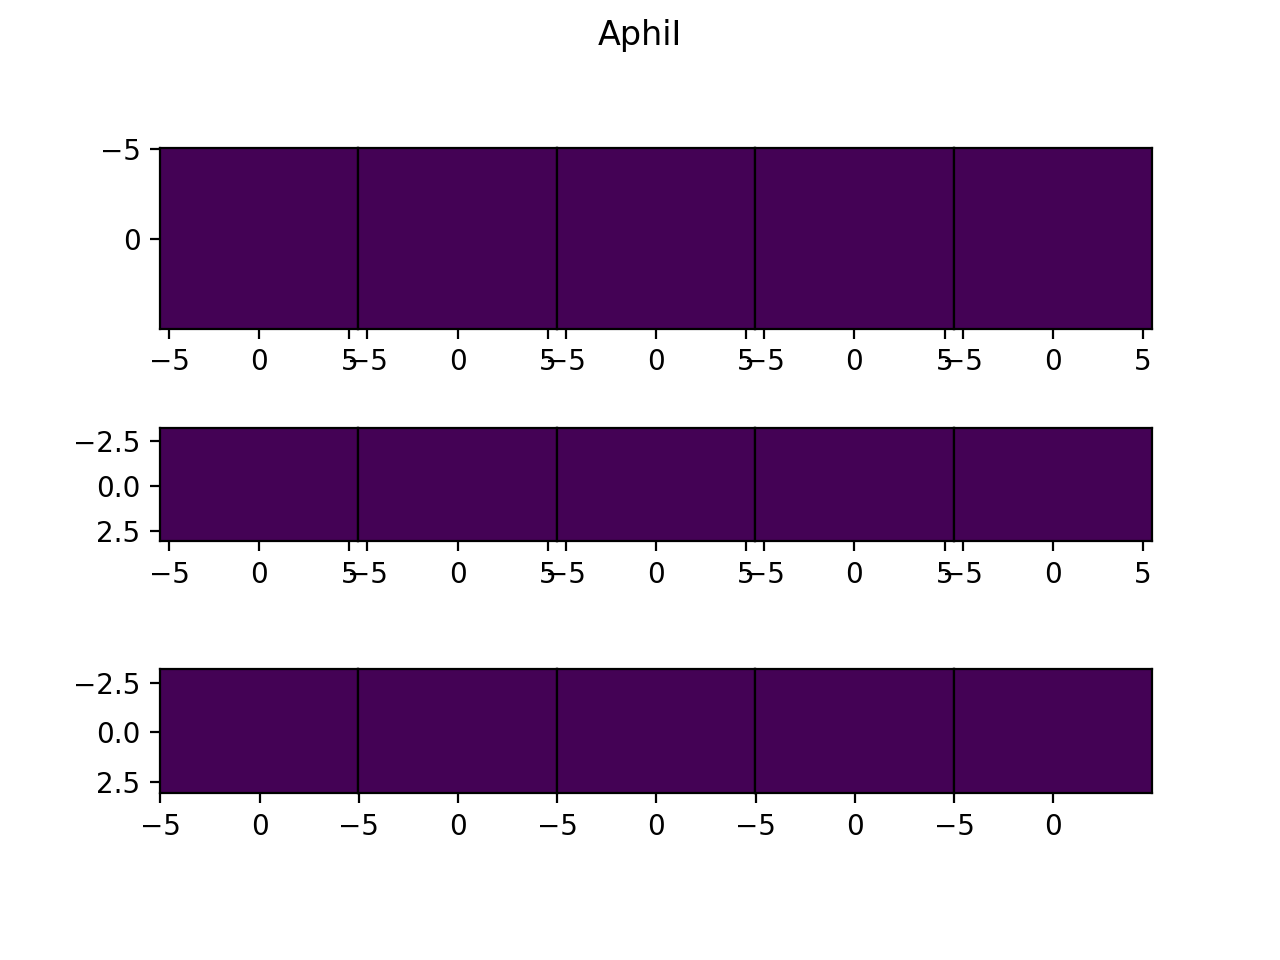

<IPython.core.display.Javascript object>


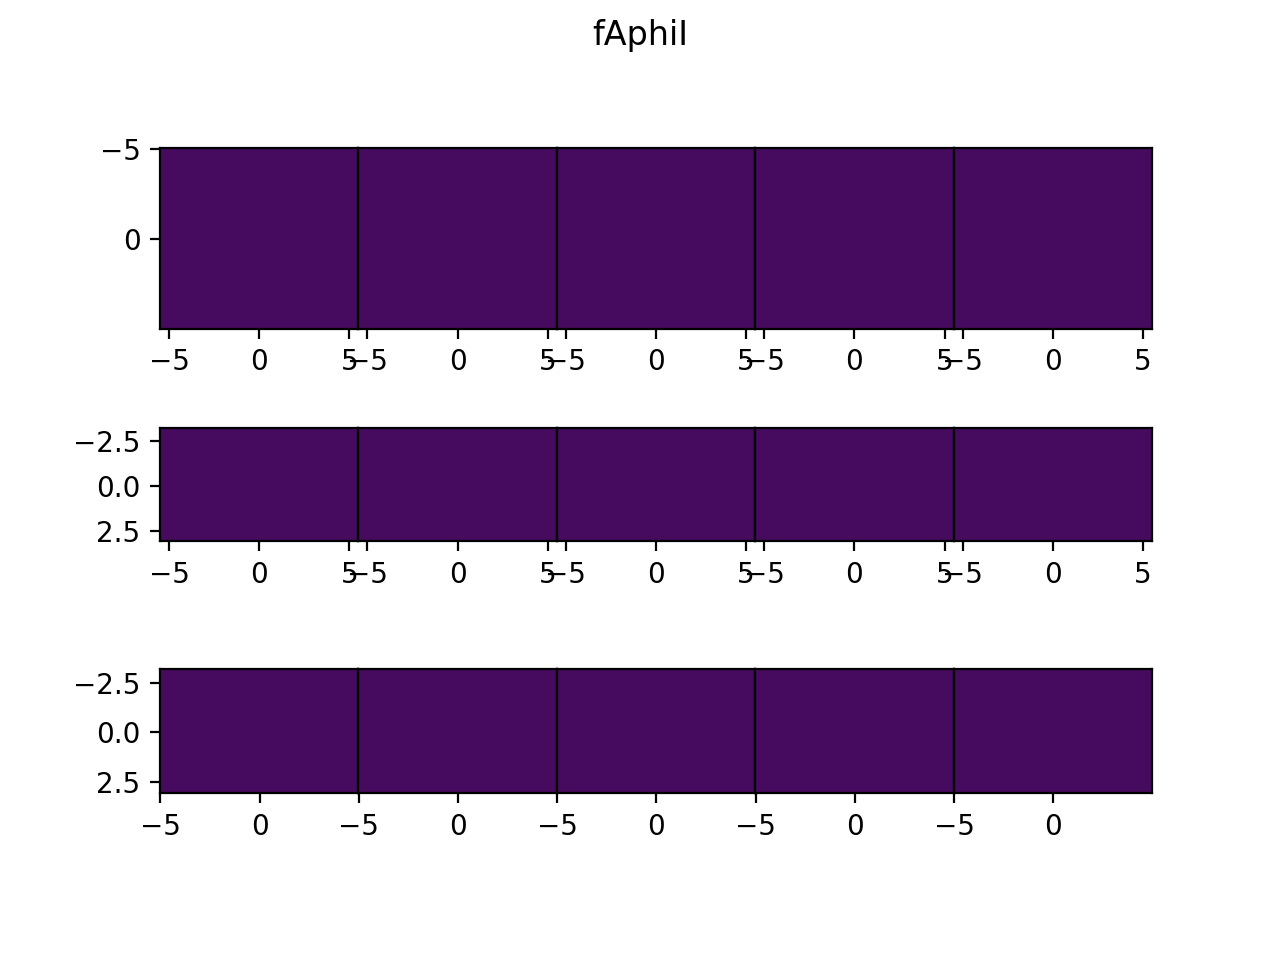

<IPython.core.display.Javascript object>


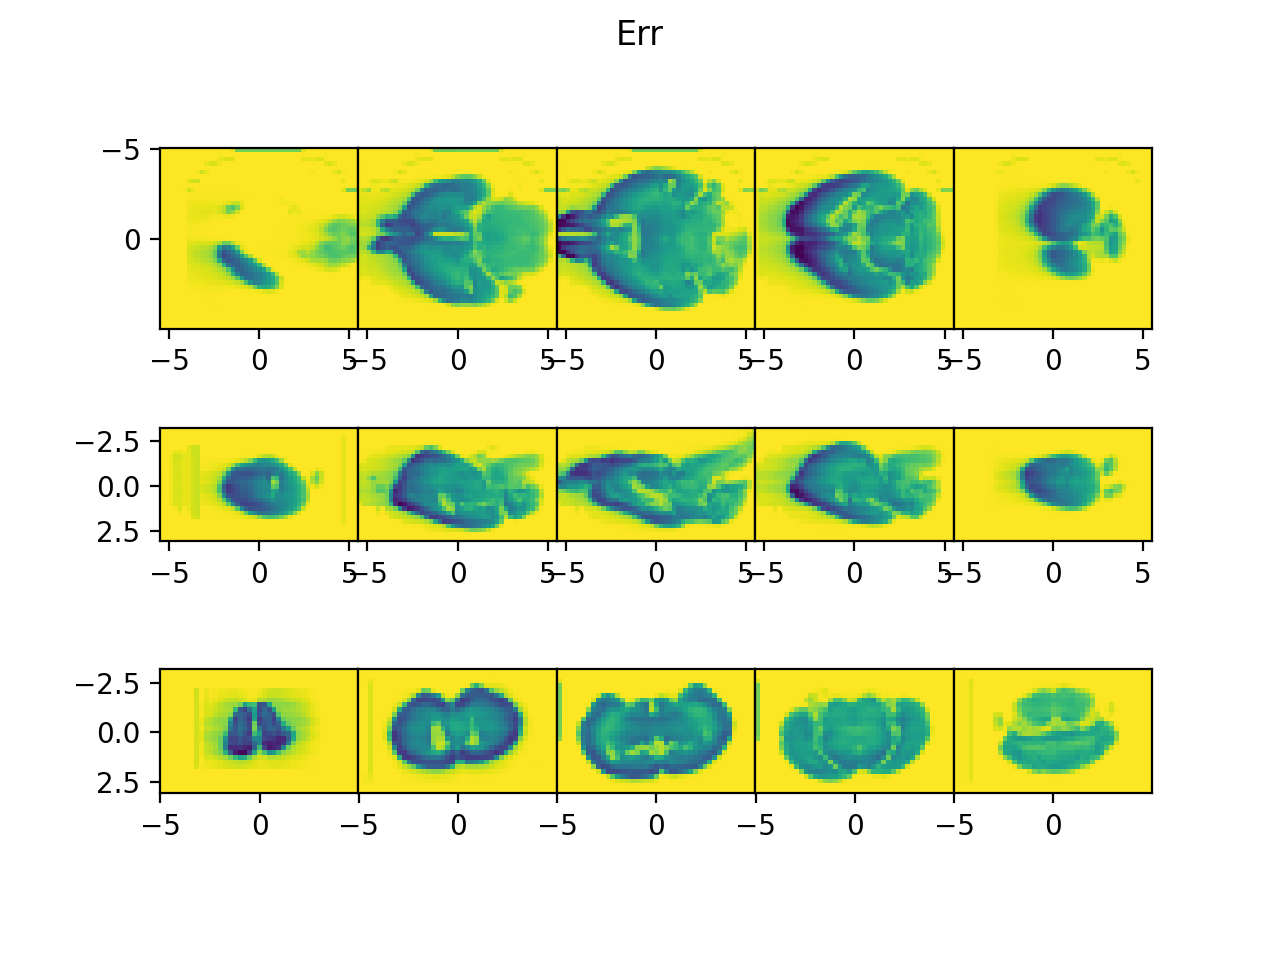

<IPython.core.display.Javascript object>


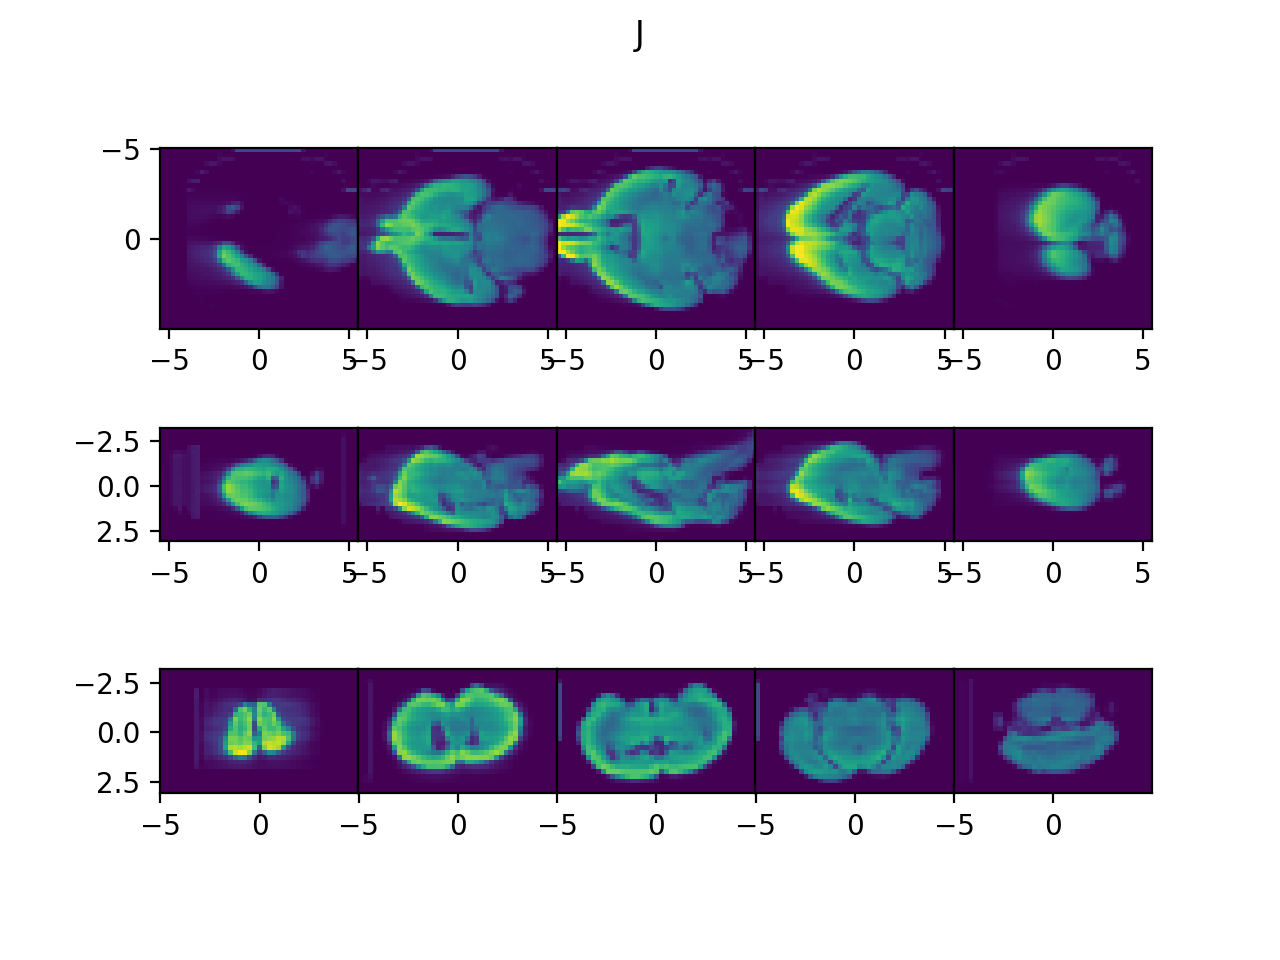

<IPython.core.display.Javascript object>


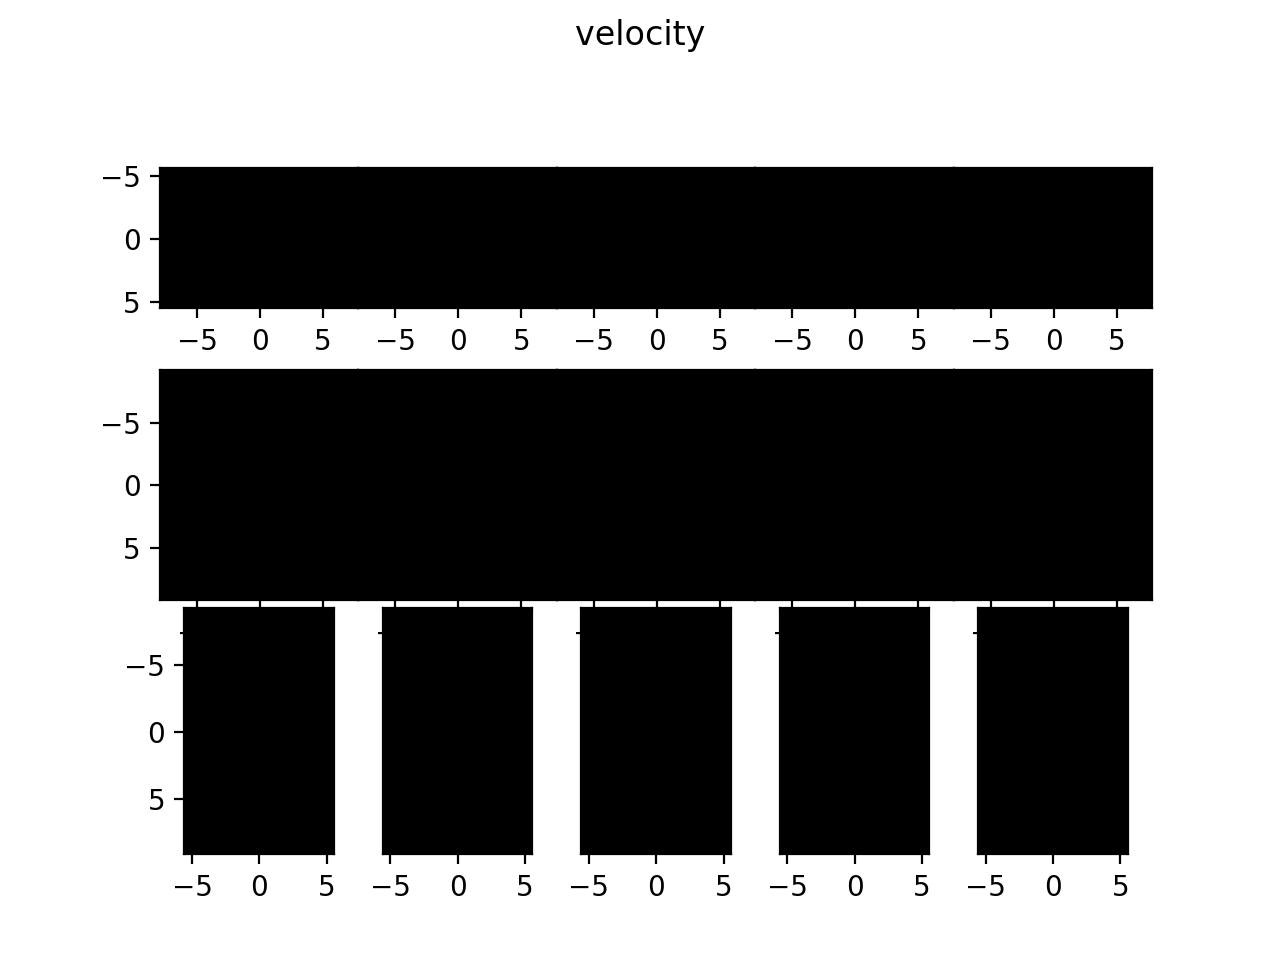

<IPython.core.display.Javascript object>


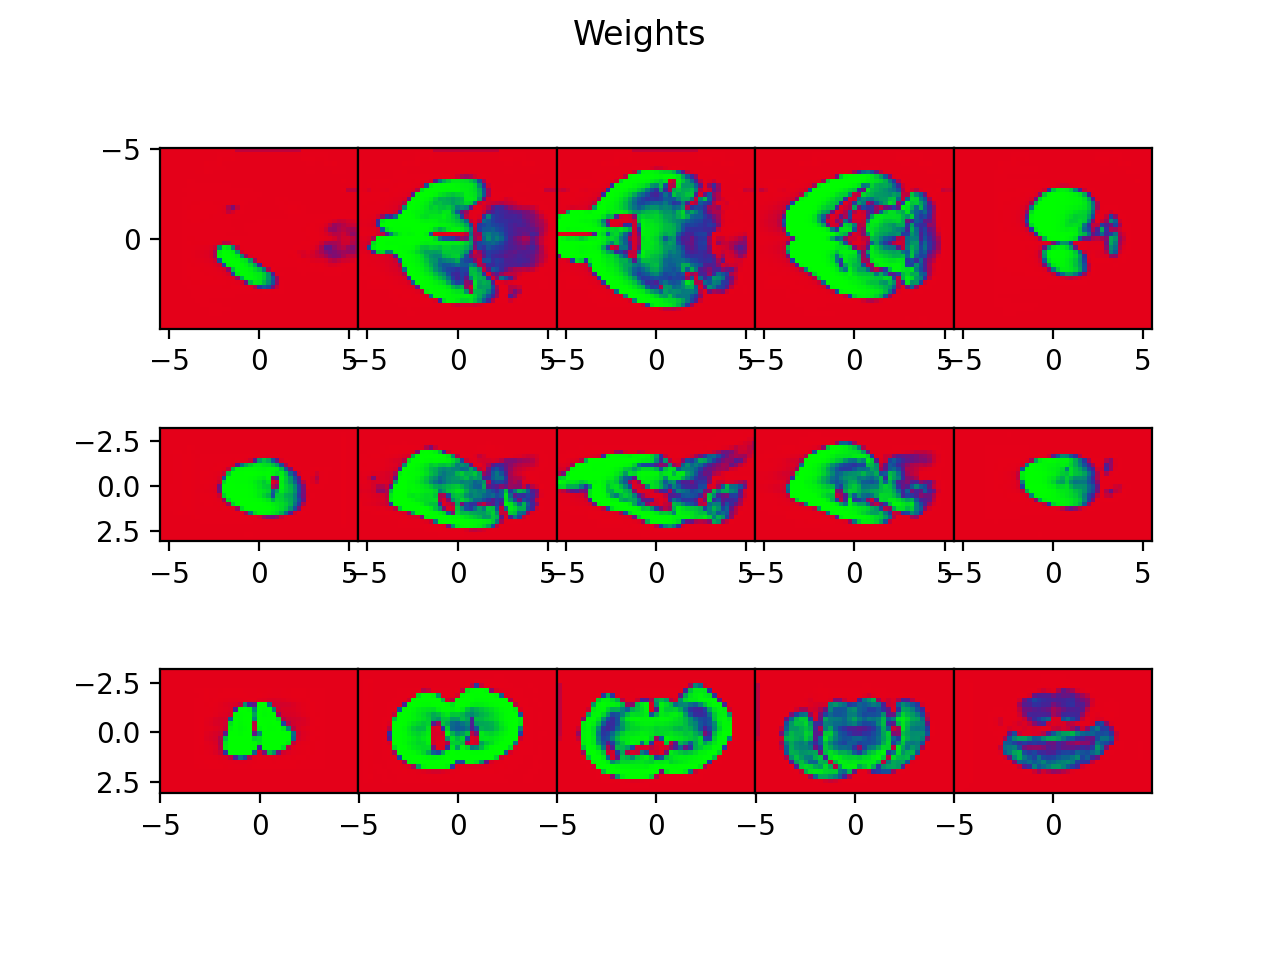

/Users/brysongray/TwardLab/emlddmm/emlddmm.py:89: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 0
Finished iteration 10
Finished iteration 20
Finished iteration 30
Finished iteration 40


/Users/brysongray/TwardLab/emlddmm/emlddmm.py:89: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


saving transformations to /Users/brysongray/TwardLab/emlddmm/demo_outputs...
saving qc to /Users/brysongray/TwardLab/emlddmm/demo_outputs...
cpu
output dir is /Users/brysongray/TwardLab/emlddmm/demo_outputs/fMOST/CCF_to_fMOST/qc/


<IPython.core.display.Javascript object>


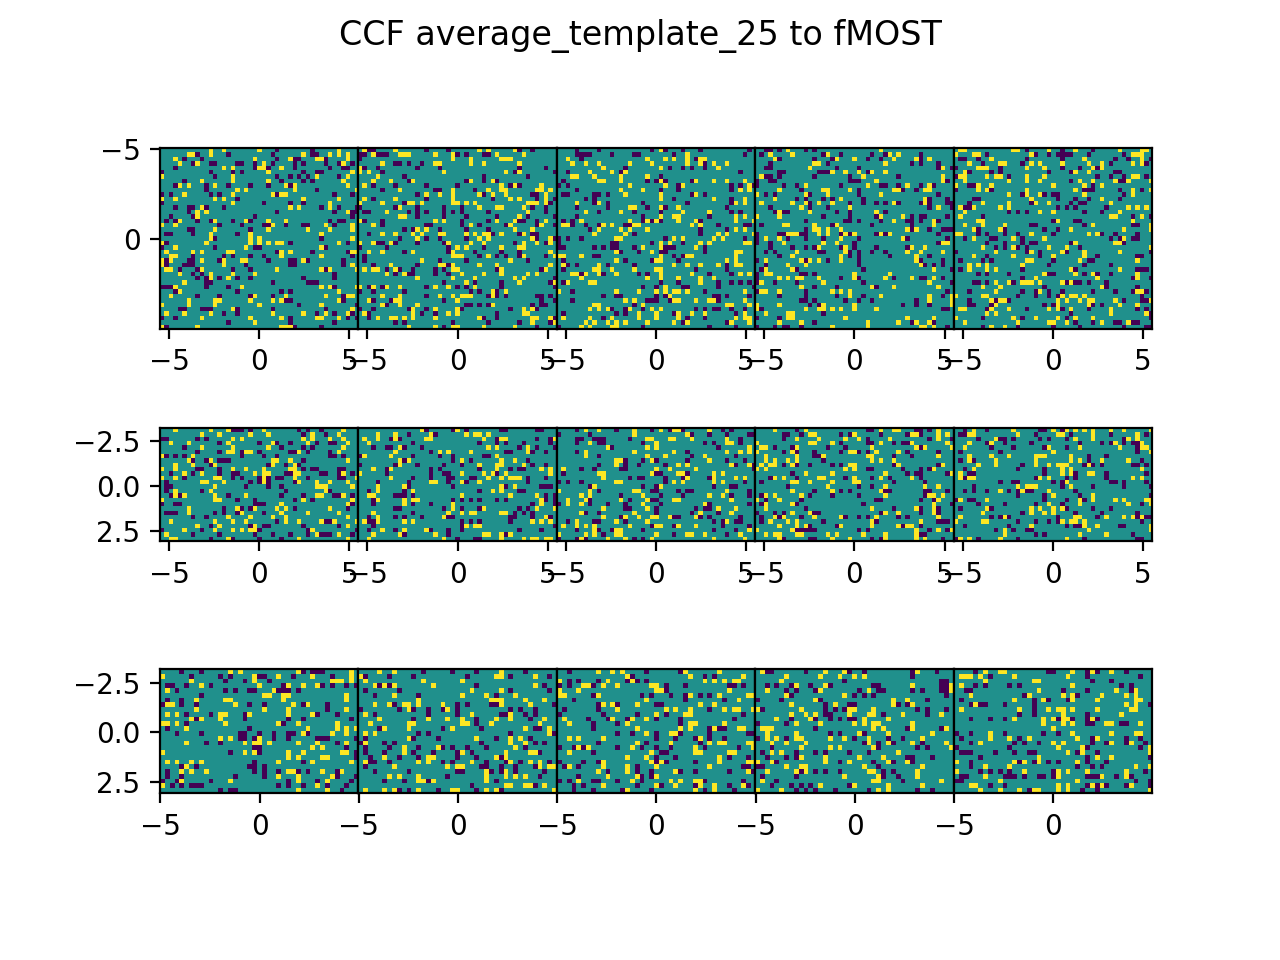

/Users/brysongray/TwardLab/emlddmm/emlddmm.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


<IPython.core.display.Javascript object>


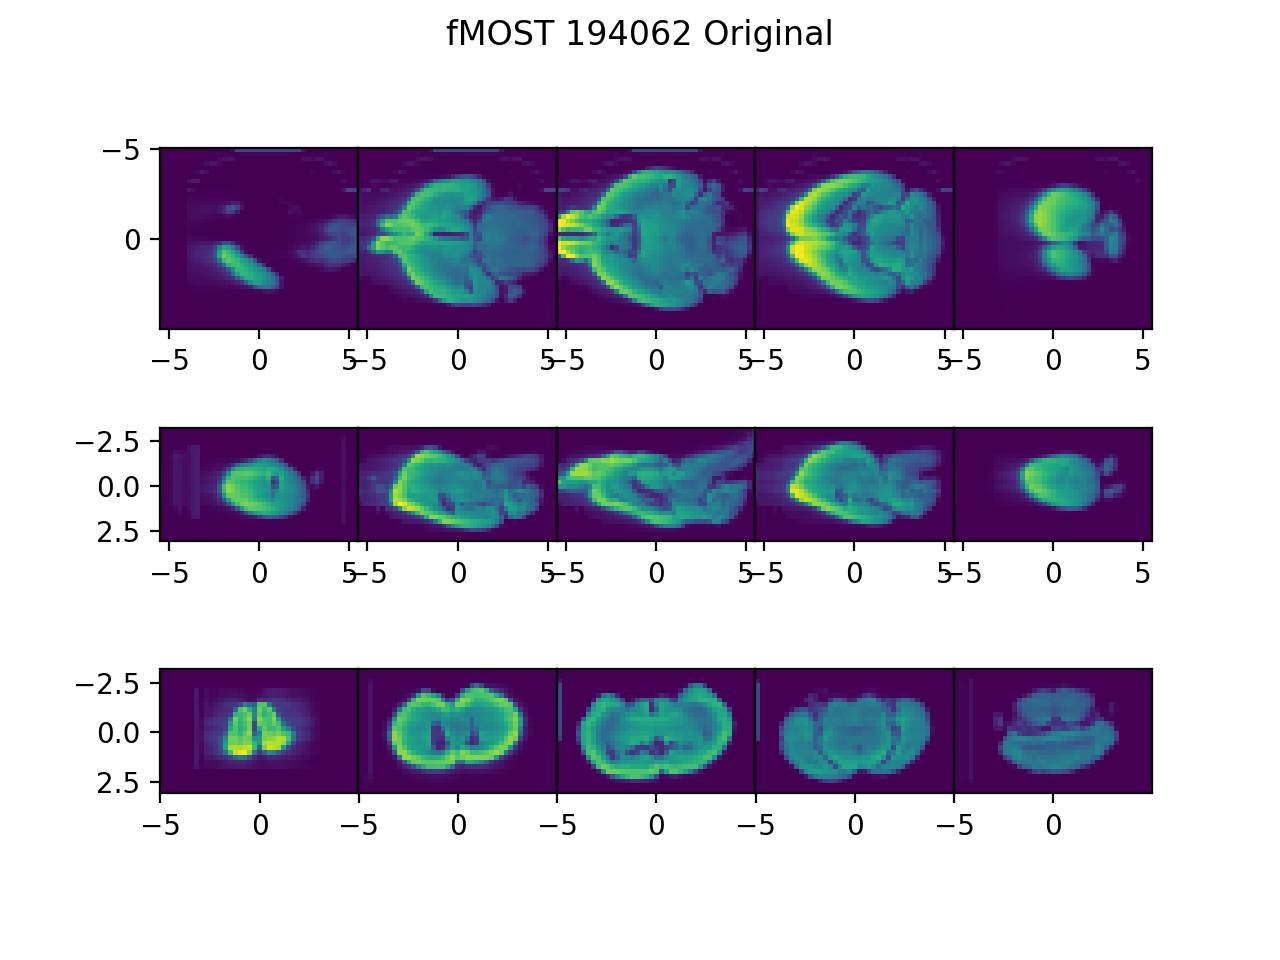

output dir is /Users/brysongray/TwardLab/emlddmm/demo_outputs/CCF/fMOST_to_CCF/qc/


<IPython.core.display.Javascript object>


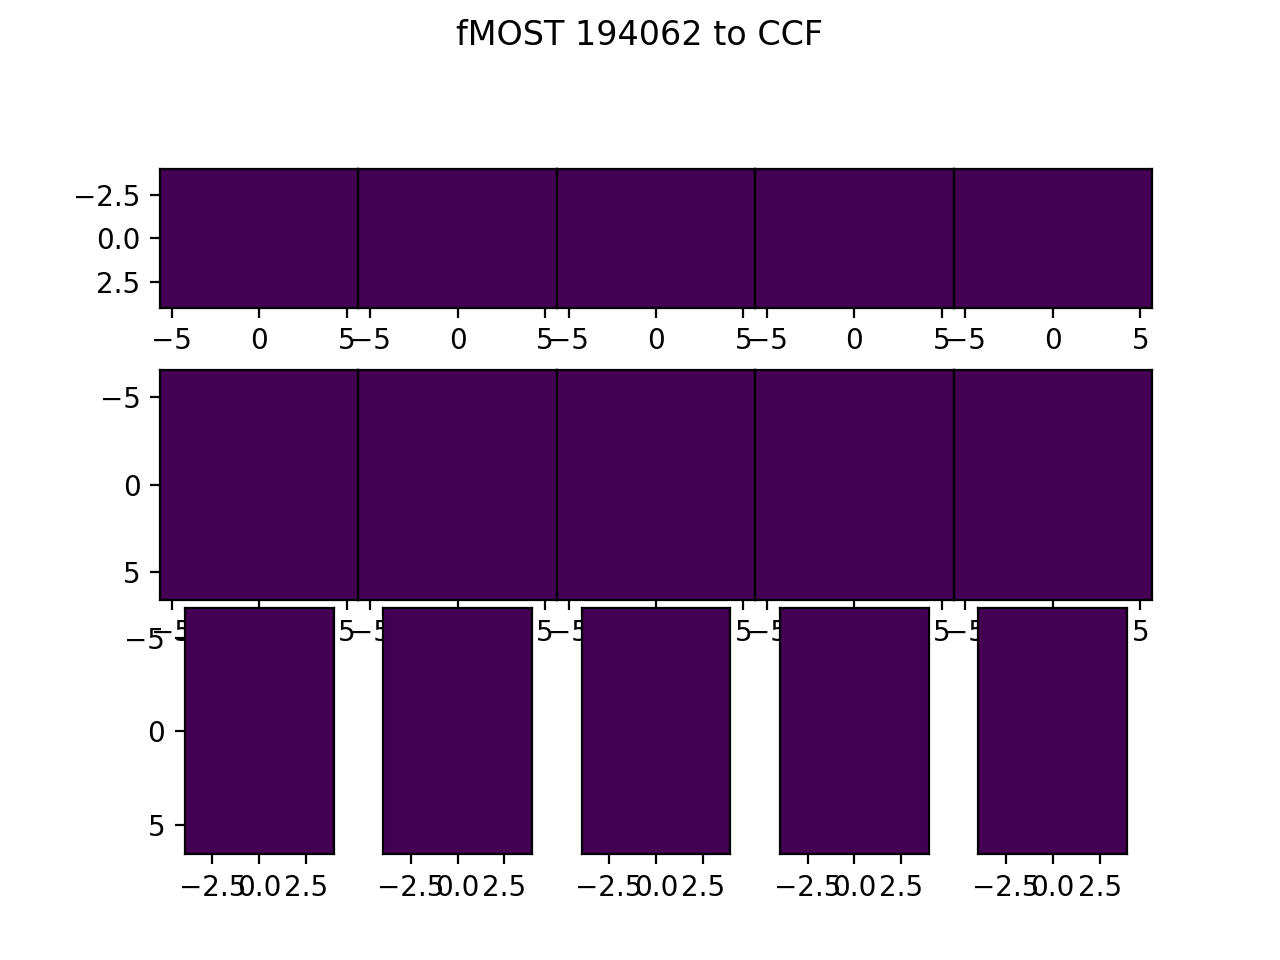

<IPython.core.display.Javascript object>


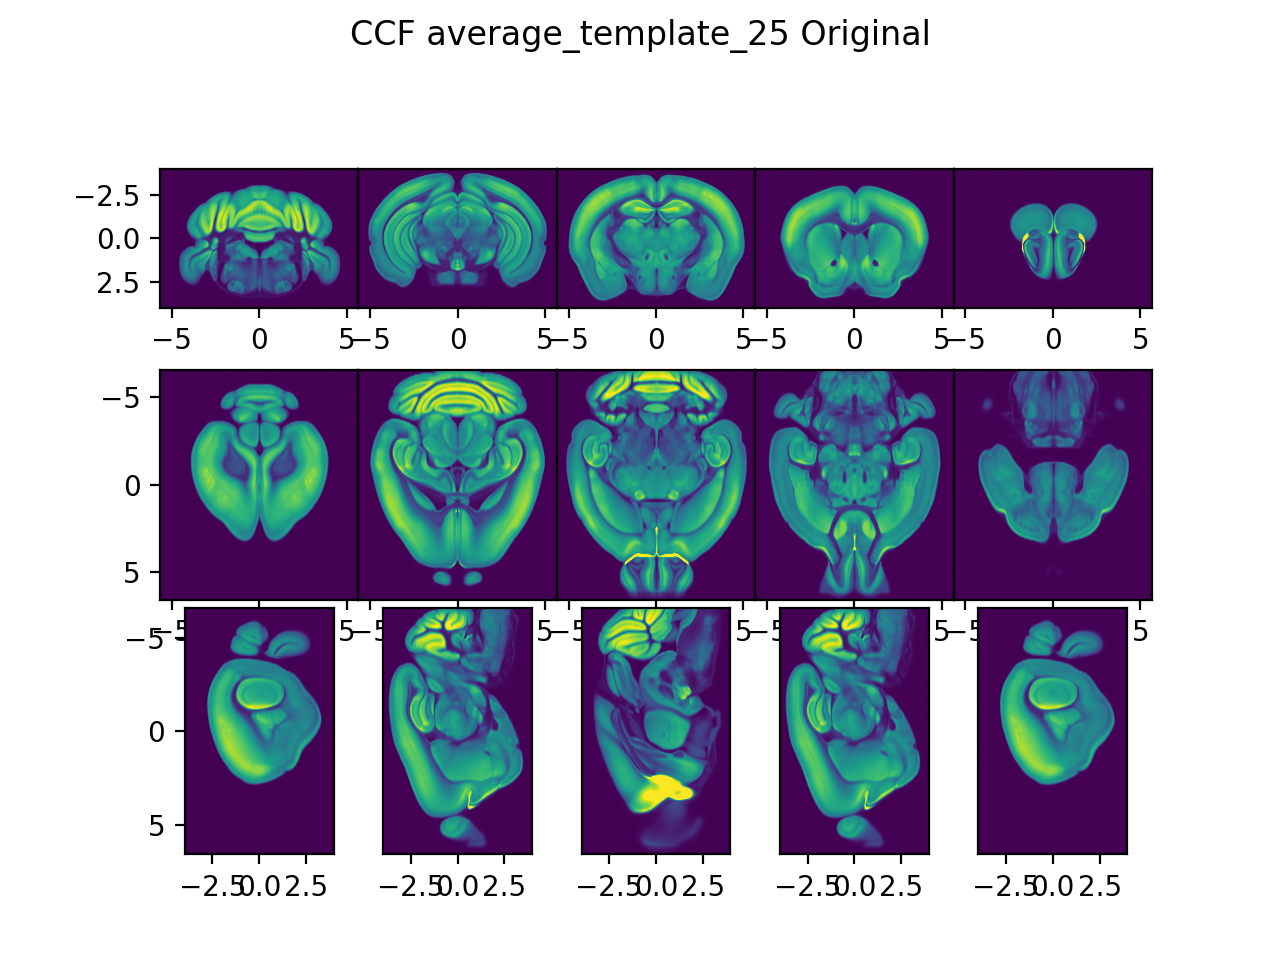

In [19]:
output_dir = '/Users/brysongray/TwardLab/emlddmm/demo_outputs'
src_space = 'fMOST'
src_img = '194062'
dest_space = 'CCF'
dest_img = 'average_template_25'

if 'device' not in config:
    config['device'] = 'cpu'
output = emlddmm.emlddmm_multiscale(I=I,xI=[xI],J=J,xJ=[xJ],W0=W0,full_outputs=True,**config)
#write outputs
print('saving transformations to ' + output_dir + '...')
emlddmm.write_transform_outputs(output_dir, src_space, dest_space, output[-1], src_path)
print('saving qc to ' + output_dir + '...')
emlddmm.write_qc_outputs(output_dir, src_space, src_img, dest_space, dest_img, output[-1],xI,I,xJ,J)